# `Brax` pipeline adapted from `dm_control`
<img src="https://github.com/google/brax/raw/main/docs/img/a1.gif" width="200" height="200"> 
<img src="https://github.com/google/brax/raw/main/docs/img/humanoid_v2.gif" width="200" height="200"> 
<img src="https://github.com/google/brax/raw/main/docs/img/ant_v2.gif" width="200" height="200"> 
<img src="https://github.com/google/brax/raw/main/docs/img/ur5e.gif" width="200" height="200"> 

dm_control provides a very high level abstraction of Mujoco, which are both implemented by Google Deepmind. **This repository takes a lot of time to parse through it, understand it, and see how each things fit together, but this is very needed as this is the fundamental skills that is needed in research and developing new things:**
1. It is the first step towards understanding what you need to do to create.
2. It is also generally a good skill to have when learning a very powerful highly abstarcted new tool, parsing through many repository classes, seeing how classes' hierchy is connected and how to find the `right level of abstraction`, seeing inherietence relationships between classes and chasing back all the way to the begining.

# Linux GPU Rendoring
##### These are imports, installation, and switch backends needed for `Linux GPU Rendoring`
- osmesa is working, all dependencies are installed, but Mujoco rendoring does not support osmesa, only the other ones, which does have installation issues
- specifically the `mujoco.viwer` packages

In [1]:
# #@title Colab Only
# !pip install brax
# !pip install wandb
# !pip install mujoco
# !pip install dm_control
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
# !pip install tqdm

In [2]:
# import distutils.util
# import os
# import subprocess

# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/bin/nvidia-smi'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# # Configure MuJoCo to use the EGL rendering backend (requires GPU)
# print('Setting environment variable to use GPU rendering:')

# !PYOPENGL_PLATFORM=osmesa
# %env MUJOCO_GL=osmesa
# os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
# !pip install --upgrade PyOpenGL PyOpenGL_accelerate

# Environment Building
References to dm_control implementation of customized environment. These are the super high level libs, locomotion lib should have everything to get a rl agent running in dm control and the mjcf lib should have everything about building a connection class.
- [dm_control locomotion lib](https://github.com/google-deepmind/dm_control/tree/main/dm_control/locomotion)
- [dm_control mjcf lib](https://github.com/google-deepmind/dm_control/tree/main/dm_control/mjcf)
- [dm_control lib](https://github.com/google-deepmind/dm_control/tree/main)
- [mujoco](https://mujoco.readthedocs.io/en/3.1.1/overview.html)
- [brax](https://github.com/google/brax)

# Organization
- `locomotion class`
  - `arena subclass`
    - i.e. corridors -> gap corridors
  - `walkers subclass`
    - assets (xml)
    - i.e. rodent -> rat
  - `tasks subclass`
    - i.e. jump gaps
- `mjcf class`
  - class we want to build using idea from corridors
- `composer class`
  - arena.py/arena.xml provides foundation for `locomotion class`

  This really took a quite long time to figure out:
  1. We can use `tasks_subclass` by converting it to mjcf model, then MjModel
  2. Inherentence can be used to build pur own functions needed in `task`, `arena`, and `walker` (work smart)

## Collective Efforts
This is a lower level abstraction compare to the previous one, but it is still really high level, calling functions and environental setup that dm_control have already implemented.

The skill now is to parse through these very convoluted layers to see the `real idea` behind all the implementation and the `pipeline` of how each things are called. In this way, you can know all the way to the implementation level and then decide on which `level of abstraction` you want to stay on to achieve the purpose you need while fixing minimum things and utilize functions that others have already written to complete your goals so
>### You can spend the time on building on top of it and actually doing more useful things to create new innovations instea of doing redendent work. Then later your work may become a function, a abstraction level, that other people call to build more works in the field. This is a collaboration project that takes a collective effort towards a common goal, this is the powerfullness of python libs, to not reinvent the wheels but use the wheels to build the car, to not recreate data structure for storing data but use the data for more things.

Therefore, staying on the right level of abstraction and using implemented functions is very important (just like we used brax implementation of ppo, we can use dm_control's implementation of customized env)

- Brax mjx -> Mujoco env -> modify using dm_control implemented packages -> dm_control mjcf
 - On mjx level? on dm_control implemented env sample level? on mjcf level? on xml level?

 ***Do notice that these things are already at the task level, which is already an execution of (model + environment), the correct level of `abstraction` should be just the background environment level, not the task level, this is the same with brax***

In [10]:
from datetime import datetime
import functools
from IPython.display import HTML
import PIL.Image
import yaml
from typing import List, Dict, Text, Callable, NamedTuple, Optional, Union, Any, Sequence, Tuple
from matplotlib import pyplot as plt
import mediapy as media
import wandb

import numpy as np

from etils import epath
from flax import struct
from ml_collections import config_dict

import mujoco
from mujoco import mjx

from dm_control import mjcf as mjcf_dm
from dm_control import composer
from dm_control.locomotion.examples import basic_rodent_2020
from dm_control.composer.variation import distributions
from dm_control.locomotion.arenas import corridors as corr_arenas
from dm_control.locomotion.tasks import corridors as corr_tasks
from dm_control.locomotion.walkers import rodent, ant
from dm_control import viewer
from dm_control import mujoco as mujoco_dm

import jax
from jax import numpy as jp
from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, MjxEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, model
from brax.io import mjcf as mjcf_brax

# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# np.set_printoptions(precision=3, suppress=True, linewidth=100)

## `dm_conrol` - Task Level Running
This code is directly implementation in the Mujoco framework:

There are existing examples of the framework that calls from more basic components of the dm control lib. These examples are already super high level abstractions already

In [11]:
_CONTROL_TIMESTEP = .02
_PHYSICS_TIMESTEP = 0.001
random_state=None

walker = rodent.Rat(observable_options={'egocentric_camera': dict(enabled=True)})

  # Build a corridor-shaped arena with gaps, where the sizes of the gaps and
  # platforms are uniformly randomized.
arena = corr_arenas.GapsCorridor(
      platform_length=distributions.Uniform(.4, .8),
      gap_length=distributions.Uniform(.05, .2),
      corridor_width=2,
      corridor_length=40,
      aesthetic='outdoor_natural')

  # Build a task that rewards the agent for running down the corridor at a
  # specific velocity.
task = corr_tasks.RunThroughCorridor(
      walker=walker,
      arena=arena,
      walker_spawn_position=(5, 0, 0),
      walker_spawn_rotation=0,
      target_velocity=1.0,
      contact_termination=False,
      terminate_at_height=-0.3,
      physics_timestep=_PHYSICS_TIMESTEP,
      control_timestep=_CONTROL_TIMESTEP)

env_composed = composer.Environment(time_limit=30,
                              task=task,
                              random_state=random_state,
                              strip_singleton_obs_buffer_dim=True)

In [12]:
#viewer.launch(environment_loader=env_composed)

# `dm_control` Arena Backbone Level
These are just the the backbone skeleton in the [Arena_folder](https://github.com/google-deepmind/dm_control/tree/main/dm_control/locomotion/arenas)
- Gap Corridor -> Empty Corridor -> Corridor -> composer.arena -> xml
- Rodent -> xml
## First Idea:
Making the intermediate class that connects the corridor defined environment (corridor environment is in the arena folder, not the task folder)
* [Tasks_folder](https://github.com/google-deepmind/dm_control/tree/main/dm_control/locomotion/tasks) is directly running the algorithm already
* [Arena_folder](https://github.com/google-deepmind/dm_control/tree/main/dm_control/locomotion/arenas) provides the actual skeleton, this is the correct level of `abstraction` that we are looking for
* > ##### Tasks = Walker + Arena

> ##### problem: we can not directly use the arena implemented by dm_control nor can we use the walker implemented by dm_control, they are too specifically designed by dm_control

## Second Idea:
1. Directly build an arena through intuitions from the corriodr class
2. Link the rodent or humanoid xml to such environment
3. because it is created by the mjcf class in dm_control, we can directly export it as a fix file and it cna be utilized in brax
    - essentially we skip some of the really convoluted implementation of dm_control from `tasks -> arena + walker -> composer class -> xml`
    - we are directly building it from scratch using `mjcf.RootElement()`
4. mjcf model here direcly uses Mujoco, there is no need to initiate another mujoco in brax training loop, we directly pass an model into brax

> ##### problem: this is way too inefficient and there should be a much smarter way working with it

## Third Idea:
1. Seems like that the Corridor class can be directly transfered into a mjcf model by `.to_mjcf_model()`
2. Also self implemented a Corridor class that is directly based on `mjcf.RootElement()` and return the model using `.out()` functions
3. Try to inherent directly from the Corridor class and assing some more things

> ##### problem: so far Inherent class idea is implemented quite well, but binding not assigned

## Forth Idea:
1. Directly wrap evrything once `binding` is down with the agent and also the environment at the `tasks` level
2. task level can also be exported as an mjcf_model file and the same storing as in MjModel once ptr, same with the brax humanoid that was previously implemented in the training loop.
3. Created inherietence from task module and the directly bind it to an existing waler construct file (fix ours later)

> ##### problem: this `task wrapper binded model` has friction setup that Mujoco does not support

# Directly Inherent Class for Brax
### Primary Goal:
1. Create direct inheritence that from dm_control (`walker, arena, tasks -> wrapper to physics`)
2. Build a pipeline for using customization functions from dm_control for brax training by implementing particular classes that we can change to fit our our needs for the `arena`, `walker`, and `tasks binding` (binds walker and arena).

In [13]:
class Gap_Vnl(corr_arenas.GapsCorridor):
    def _build(self, corridor_width, corridor_length, visible_side_planes, aesthetic, platform_length, gap_length):
        super()._build(corridor_width=corridor_width,
                       corridor_length=corridor_length,
                       visible_side_planes=visible_side_planes,
                       aesthetic = aesthetic,
                       platform_length = platform_length,
                       gap_length = gap_length)

        # self.walker = mjcf.from_path("./models/rodent_dm_control.xml")
        # # Initiate walker
        # self.spawn_pos = (0, 0, 0)
        # self.spawn_site =  self._mjcf_root.worldbody.add('site', pos=self.spawn_pos)
        # self.spawn_site.attach(self.walker).add('freejoint')
    
    def regenerate(self, random_state):
        super().regenerate(random_state)

class Task_Vnl(corr_tasks.RunThroughCorridor):
    def __init__(self,
               walker,
               arena,
               walker_spawn_position,
               walker_spawn_rotation=None,
               target_velocity=3.0,
               contact_termination=True,
               terminate_at_height=-0.5,
               physics_timestep=0.005,
               control_timestep=0.025):
        super().__init__(walker=walker,
                         arena=arena,
                         walker_spawn_position=walker_spawn_position,
                         walker_spawn_rotation=walker_spawn_rotation,
                         target_velocity=target_velocity,
                         contact_termination=contact_termination,
                         terminate_at_height=terminate_at_height,
                         physics_timestep=physics_timestep,
                         control_timestep=control_timestep)
        
# Implement Walker Class

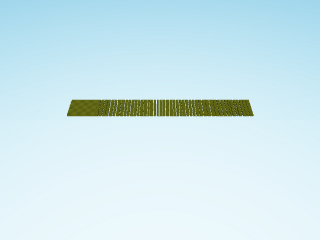

In [38]:
arena = Gap_Vnl(platform_length=distributions.Uniform(.4, .8),
      gap_length=distributions.Uniform(.05, .2),
      corridor_width=5, # walker width follows corridor width
      corridor_length=40,
      aesthetic='outdoor_natural',
      visible_side_planes=False)

arena.regenerate(random_state=None)
physics = mjcf_dm.Physics.from_mjcf_model(arena.mjcf_model)
PIL.Image.fromarray(physics.render())

# walker = ant.Ant(observable_options={'egocentric_camera': dict(enabled=True)})
# task = corr_tasks.RunThroughCorridor(
#     walker=walker,
#     arena=arena,
#     walker_spawn_position=(10, 0, 0),
#     walker_spawn_rotation=0,
#     target_velocity=1.0,
#     contact_termination=False,
#     terminate_at_height=-0.3)

# random_state = np.random.RandomState(12345)
# task.initialize_episode_mjcf(random_state)
# physics = mjcf_dm.Physics.from_mjcf_model(task.root_entity.mjcf_model)

# Rendoring with Mujoco
We want to check if the rendoringproblem after entering brax env is caused by the MjModel itself, so we rendor it here directly fitrst to see if it actually works!

- From playing around with the rendering in mujoco, we figured out a key idea: ***camera options in the dm_control MjModel is indicated by numerical number***
1. -1 is far side view
2. 0 is closer side view
3. 1 is back view
4. 2 is closer back view
5. 3 is egocentric view

In [39]:
mj_model = physics.model.ptr
mj_model.opt.cone = mujoco.mjtCone.mjCONE_PYRAMIDAL

mjx_model = mjx.put_model(mj_model)
mj_data = mujoco.MjData(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 5  # (seconds)
framerate = 60  # (Hz)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
while mj_data.time < duration:
  mujoco.mj_step(mj_model, mj_data)
  if len(frames) < mj_data.time * framerate:
    renderer.update_scene(mj_data, scene_option=scene_option,camera=0)
    pixels = renderer.render()
    frames.append(pixels)

# Simulate and display video.
media.show_video(frames, fps=framerate)

ValueError: cannot reshape array of size 0 into shape (0)

# Jax stepping version
Checksing with Jax stepping

In [ ]:
jit_step = jax.jit(mjx.step)

frames = []
mujoco.mj_resetData(mj_model, mj_data)
mjx_data = mjx.put_data(mj_model, mj_data)
while mjx_data.time < duration:
  mjx_data = jit_step(mjx_model, mjx_data)
  if len(frames) < mjx_data.time * framerate:
    mj_data = mjx.get_data(mj_model, mjx_data)
    renderer.update_scene(mj_data, scene_option=scene_option)
    pixels = renderer.render()
    frames.append(pixels)

media.show_video(frames, fps=framerate)

# Walker Class Adapted
Instead of directly getting the `Mujoco xml` or `mjcf` file, we get it directly by instantiating an customized `dm_control pymjcf` class and then extract it from there directly.

In [ ]:
class Walker(MjxEnv):
  '''
  This is greatly coustomizable of what reward you want to give: reward engineering
  '''
  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 1.5),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,):
    '''
    Defining initilization of the agent
    '''

    mj_model = physics.model.ptr
    # this is directly a mj_model already of type mujoco_py.MjModel (This is already a MJModel, same as previously in brax)
    # the original xml load is directly creaing an new MjModel instance, which carries the configuration of everything, including mjtCone
    # but this pass in one doesn't, it uses the default mjCONE_PYRAMIDAL, but MjModel now uses the eliptic model, so reset is needed

    # solver is an optimization system
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.cone = mujoco.mjtCone.mjCONE_PYRAMIDAL # Read documentation

    #Iterations for solver
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    # Defult framne to be 5, but can self define in kwargs
    physics_steps_per_control_step = 5
    
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)

    # Parents inheritence from MjxEnv class
    super().__init__(model=mj_model, **kwargs)

    # Global vraiable for later calling them
    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (exclude_current_positions_from_observation)

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""

    #Creating randome keys
    #rng = random number generator key for starting random initiation
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale

    #Vectors of generalized joint position in the configuration space
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )

    #Vectors of generalized joint velocities in the configuration space
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    #Reset everything
    obs = self._get_obs(data.data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    #Previous Pipeline
    data0 = state.pipeline_state

    #Current pipeline state, step 1
    data = self.pipeline_step(data0, action)

    #Running forward (Velocity)
    com_before = data0.data.subtree_com[1]
    com_after = data.data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0] * 2

    #Height being healthy
    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)

    #Termination condition
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    #Control quad cost
    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    #Feedback from env
    obs = self._get_obs(data.data, action)
    reward = forward_reward + healthy_reward - ctrl_cost

    #Termination State
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0

    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(self, data: mjx.Data, action: jp.ndarray) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    # environment observation described later
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])
  
# Registering the environment setup in env as humanoid_mjx
envs.register_environment('walker', Walker)

## Rendoring a Rollout
You can not render rollout on a non-linux machine as you need `ffmpeg`, which only exist on linux (previously thought), now rendoring on mac works just fine!
But the environment actually works -> establishes and step successfuly. You need to run this pipeline in:
1. Linux Server
2. Gpu based and having neccessary colab import and installation

dm_control model did implement `camera`, but the name is different from brax's model, so we need to find the specific name for the specific model (camera is usually implemeneted in the walker's xml file, it is not something that is normally directly ccaried by MjModle, but it can be set as well):

camera default argument is actually None in brax documentation here in this [line](https://github.com/google/brax/blob/a89322496dcb07ac5a7e002c2e1d287c8c64b7dd/brax/envs/base.py#L205)

In [ ]:
env = envs.get_environment(env_name='walker')

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# initialize the state
state = jit_reset(jax.random.PRNGKey(0))

#Creating an container for rollout states
rollout = [state.pipeline_state]

# grab a trajectory
for i in (range(100)):
    ctrl = -0.1 * jp.ones(env.sys.nu)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

# media.show_video(env.render(rollout,camera=None), fps=1.0 / env.dt)

In [ ]:
media.show_video(env.render(rollout,camera=1), fps=1.0 / env.dt)

## Debugging Logs & Ideas:
1. Follow error message and function descriptions, check all the way to `mujoco` render level, then to `brax`
2. Ran mujoco rnder separately, `MjModel` is able to render
3. brax render uses mujoco render, mujoco render works fine, the `MjModel` should be correct, may be problem with `states` in rollout `trajectory`
4. problem probably occur on this [line](https://github.com/google/brax/blob/a89322496dcb07ac5a7e002c2e1d287c8c64b7dd/brax/envs/base.py#L214) where `d` has shape of 8 but renderer only takes in shape of 7
5. We may need to define our own rendoring function by shrinking some of the inputting array in `d`
6. It may be the env setup for brax here is for humanoid, not for ant (humanoid model in dm_control has mj_mopdel.geo_condim issue (mjx only support geo_condium of 3) and rodent has tendon issue)
7. Reimplemented ant using a simpler implementation instead of the complex one, seems like still encounter the issue
8. May have to reimplement the walker class first for this to work
    - check geom_condim
    - check tendon
9. The mismatch issue may come from mismatch training loop
10. previous wrong understanding, training loop for brax env is correct, wrong looking previously because we direcly load in state, not loading in `.Data`
11. indeed it is still this [line](https://github.com/google/brax/blob/a89322496dcb07ac5a7e002c2e1d287c8c64b7dd/brax/envs/base.py#L214) that have error occuring, I implemented the rendoring function step by step and it is at this step the error message `ValueError: could not broadcast input array from shape (8,) into shape (7,)` occurs
12. Now actually everything works! Practiced debugging going to really small detailed level and trying out bit by bit.

### Really getting in-depth understanding
What `mjx.get_data` is getting really is the date of one aspect of the rollout, or one state of it `rollout[i]`. so `state.data`

In [ ]:
def render(
      self, trajectory: List[base.State], camera: Union[str, None] = None
  ) -> Sequence[np.ndarray]:
    """Renders a trajectory using the MuJoCo renderer."""
    renderer = mujoco.Renderer(self._model)
    camera = camera or -1

    def get_image(state: mjx.Data):
      d = mjx.get_data(self._model, state) # This line have error occuring, shows same error message
      mujoco.mj_forward(self._model, d)
      renderer.update_scene(d, camera=camera)
      return renderer.render()

    return [get_image(s.data) for s in trajectory]  # pytype: disable=attribute-error

In [ ]:
from mujoco.mjx._src import constraint
from mujoco.mjx._src import types

##### Idea 1: Know which component is which when calling, take important part that is relevant to debugging and then run separately

In [ ]:
# brax renderer level
d = rollout[0].data
m = mj_model

# mjx.get_data level
result = mujoco.MjData(mj_model)

# mjx.get_data_into level
d = jax.device_get(d)
batched = isinstance(result, list)
batch_size = d.qpos.shape[0] if batched else 1

# for i in range(batch_size):
#     d_i = jax.tree_map(lambda x, i=i: x[i], d) if batched else d
#     result_i = result[i] if batched else result
#     efc_active = (d_i.efc_J != 0).any(axis=1)
#     nefc = efc_active.sum()
#     result_i.efc_J_rownnz[:] = np.repeat(m.nv, nefc)
#     result_i.efc_J_rowadr[:] = np.arange(0, nefc * m.nv, m.nv)

##### Idea 2: Take out big chunk of the code and try to remove different things to see what is causing the shape error

In [ ]:
ne, nf, nl, nc = constraint.count_constraints(m)
efc_type = np.array([
    mujoco.mjtConstraint.mjCNSTR_EQUALITY,
    mujoco.mjtConstraint.mjCNSTR_FRICTION_DOF,
    mujoco.mjtConstraint.mjCNSTR_LIMIT_JOINT,
    mujoco.mjtConstraint.mjCNSTR_CONTACT_PYRAMIDAL,
]).repeat([ne, nf, nl, nc])

dof_i, dof_j = [], []
for i in range(m.nv):
    j = i
while j > -1:
    dof_i.append(i)
    dof_j.append(j)
    j = m.dof_parentid[j]

for i in range(batch_size):
    d_i = jax.tree_map(lambda x, i=i: x[i], d) if batched else d
    result_i = result[i] if batched else result
    ncon = (d_i.contact.dist <= 0).sum()
    efc_active = (d_i.efc_J != 0).any(axis=1)
    efc_con = efc_type == mujoco.mjtConstraint.mjCNSTR_CONTACT_PYRAMIDAL
    nefc, nc = efc_active.sum(), (efc_active & efc_con).sum()
    result_i.nnzJ = nefc * m.nv
    mujoco._functions._realloc_con_efc(result_i, ncon=ncon, nefc=nefc)  # pylint: disable=protected-access
    result_i.efc_J_rownnz[:] = np.repeat(m.nv, nefc)
    result_i.efc_J_rowadr[:] = np.arange(0, nefc * m.nv, m.nv)
    result_i.efc_J_colind[:] = np.tile(np.arange(m.nv), nefc)

ValueError: could not broadcast input array from is `np.arange(0, nefc * m.nv, m.nv)` into is `result_i.efc_J_rowadr[:]`

***When running the whole structure, the shape seems to match up -> call rendor try -> call mediapy try***

##### Idea 3: Separate fundamental functions to examine them separately

Seems like the problem lays in this `mjx.get_data` function, which is [here](https://github.com/google-deepmind/mujoco/blob/8be966cdf9073813ec8b494062f4d97848432057/mjx/mujoco/mjx/_src/io.py#L235) and related to the `get_data_into` function, particularly this [line](https://github.com/google-deepmind/mujoco/blob/8be966cdf9073813ec8b494062f4d97848432057/mjx/mujoco/mjx/_src/io.py#L293). I think this is related to [this line's shape problem](https://github.com/google-deepmind/mujoco/blob/8be966cdf9073813ec8b494062f4d97848432057/mjx/mujoco/mjx/_src/io.py#L284C4-L284C47)

In [ ]:
def get_data(
    m: mujoco.MjModel, d: types.Data
) -> Union[mujoco.MjData, List[mujoco.MjData]]:
  """Gets mjx.Data from a device, resulting in mujoco.MjData or List[MjData]."""
  batched = len(d.qpos.shape) > 1
  batch_size = d.qpos.shape[0] if batched else 1

  if batched:
    result = [mujoco.MjData(m) for _ in range(batch_size)]
  else:
    result = mujoco.MjData(m)

  get_data_into(result, m, d)

  return result

In [ ]:
def get_data_into(
    result: Union[mujoco.MjData, List[mujoco.MjData]],
    m: mujoco.MjModel,
    d: types.Data,
):
  """Gets mjx.Data from a device into an existing mujoco.MjData or list."""
  batched = isinstance(result, list)
  if batched and len(d.qpos.shape) < 2:
    raise ValueError('dst is a list, but d is not batched.')
  if not batched and len(d.qpos.shape) >= 2:
    raise ValueError('dst is a an MjData, but d is batched.')

  d = jax.device_get(d)

  batch_size = d.qpos.shape[0] if batched else 1
  
  ne, nf, nl, nc = constraint.count_constraints(m)
  efc_type = np.array([
      mujoco.mjtConstraint.mjCNSTR_EQUALITY,
      mujoco.mjtConstraint.mjCNSTR_FRICTION_DOF,
      mujoco.mjtConstraint.mjCNSTR_LIMIT_JOINT,
      mujoco.mjtConstraint.mjCNSTR_CONTACT_PYRAMIDAL,
  ]).repeat([ne, nf, nl, nc])

  dof_i, dof_j = [], []
  for i in range(m.nv):
    j = i
    while j > -1:
      dof_i.append(i)
      dof_j.append(j)
      j = m.dof_parentid[j]

  for i in range(batch_size):
    d_i = jax.tree_map(lambda x, i=i: x[i], d) if batched else d
    result_i = result[i] if batched else result
    ncon = (d_i.contact.dist <= 0).sum()
    efc_active = (d_i.efc_J != 0).any(axis=1)
    efc_con = efc_type == mujoco.mjtConstraint.mjCNSTR_CONTACT_PYRAMIDAL
    nefc, nc = efc_active.sum(), (efc_active & efc_con).sum()
    result_i.nnzJ = nefc * m.nv
    mujoco._functions._realloc_con_efc(result_i, ncon=ncon, nefc=nefc)  # pylint: disable=protected-access
    result_i.efc_J_rownnz[:] = np.repeat(m.nv, nefc)
    result_i.efc_J_rowadr[:] = np.arange(0, nefc * m.nv, m.nv)
    result_i.efc_J_colind[:] = np.tile(np.arange(m.nv), nefc)

# Training Policy

In [ ]:
config = {
    "env_name": 'walker',
    "algo_name": "ppo",
    "task_name": "run",
    "num_timesteps": 30_000_000,
    "num_evals": 5,
    "episode_length": 1000,
    "num_envs": 4096,
    "batch_size": 1024,
    "num_minibatches": 32,
    "num_updates_per_batch": 4,
    "unroll_length": 5,
    }

# The functools.partial() function is a function that allow us to pre-pass in parameters
# This is literally the only thing you need to write for this training
train_fn = functools.partial(
    ppo.train, num_timesteps=config['num_timesteps'], num_evals=config['num_evals'], reward_scaling=0.1,
    episode_length=config['episode_length'], normalize_observations=True, action_repeat=1,
    unroll_length=config['unroll_length'], num_minibatches=config['num_minibatches'], num_updates_per_batch=config['num_updates_per_batch'],
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=config['num_envs'],
    batch_size=config['batch_size'], seed=0)

# Saving everything to Wandb
run = wandb.init(project="vnl_walker_customize", config=config)
wandb.run.name = f"{config['env_name']}_{config['task_name']}_{config['algo_name']}_brax"
def wandb_progress(num_steps, metrics):
    metrics["num_steps"] = num_steps
    wandb.log(metrics)

# Making inference & diectly use wandb as progress function
make_inference_fn, params, _= train_fn(environment=env, progress_fn=wandb_progress)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kaiwenbian107. Use `wandb login --relogin` to force relogin
/Users/kevinb/Desktop/salk/rodent/Brax-Rodent-Run/.venv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/kevinb/Desktop/salk/rodent/Brax-Rodent-Run/.venv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/kevinb/Desktop/salk/rodent/Brax-Rodent-Run/.venv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/kevinb/Desktop/salk/rodent/Brax-Rodent-Run/.venv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


/Users/kevinb/Desktop/salk/rodent/Brax-Rodent-Run/.venv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [ ]:
#@title Save Model
model_path = '/tmp/mjx_walker_policy'
model.save_params(model_path, params)

# Rebdor a Trajectory

In [ ]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

In [ ]:
env_name = 'walker'
env = envs.create(env_name=env_name)

jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

# initialize the state
rng = jax.random.PRNGKey(0)
state = jit_reset(rng)
rollout = [state.pipeline_state]

# grab a trajectory
n_steps = 1000
render_every = 1

for i in range(n_steps):
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_inference_fn(state.obs, act_rng)
    state = jit_step(state, ctrl)
    rollout.append(state.pipeline_state)

if state.done:
    break

media.show_video(env.render(rollout[::render_every], camera='side'), fps=1.0 / env.dt / render_every)